# Análisis de Videojuegos 


## Carga y preparación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [2]:
# Cargar datos 
df = pd.read_csv('games.csv')
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


## Paso 2. Preparación de los datos

In [3]:
# Verificar si hay valores nulos
print(df.isnull().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


In [4]:
# Convertir nombres de columnas a minúsculas y eliminar espacios
df.columns = df.columns.str.lower().str.strip()
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Rellenamos valores faltantes de ESRB con 'unknown'
df['rating'] = df['rating'].fillna('unknown')

# Revisamos cambios
df[['year_of_release', 'user_score']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year_of_release  16446 non-null  Int64  
 1   user_score       7590 non-null   float64
dtypes: Int64(1), float64(1)
memory usage: 277.6 KB


In [5]:
# Creamos la columna de ventas totales sumando las regiones
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

## Descripción de los cambios realizados:


**Explicación de los cambios:**


- Se renombraron todas las columnas a minúsculas para facilitar su manejo.
- Se convirtieron las columnas `year_of_release` y las de ventas a tipo numérico (`float`), ya que representan valores cuantitativos.
- La columna `user_score` contenía valores 'tbd' (to be determined), que se reemplazaron por valores ausentes (`NaN`) y luego se convirtió a tipo `float`.
- Eliminamos en valores ausentes (`NaN`) en `name`, `platform`, `genre` para análisis posteriores.

- La columna `rating` contenia valores ausentes (`NaN`) y fueron cambiados por `Unknown`, no afecta en el análisis .

**Posibles causas de valores ausentes:**

- Juegos recientes o poco populares pueden no tener puntuaciones de usuarios o expertos.
- 'TBD' indica que la puntuación aún no ha sido determinada.
- Algunos juegos pueden carecer de información de lanzamiento o ventas en ciertas regiones.
- No todos los juegos tienen clasificación ESRB, especialmente lanzamientos globales o antiguos.

**Decisión:** Se manejan valores ausentes dejando `NaN`, ya que imputar podría introducir sesgos. En análisis posteriores se decidirá si se eliminan o se imputan según el contexto.
Dentro la limpieza se encontraron 2 duplicados explícitos los cuales no fueron tratados ya que no afectan en el análisis. 

## Paso 3 . Analisis de datos

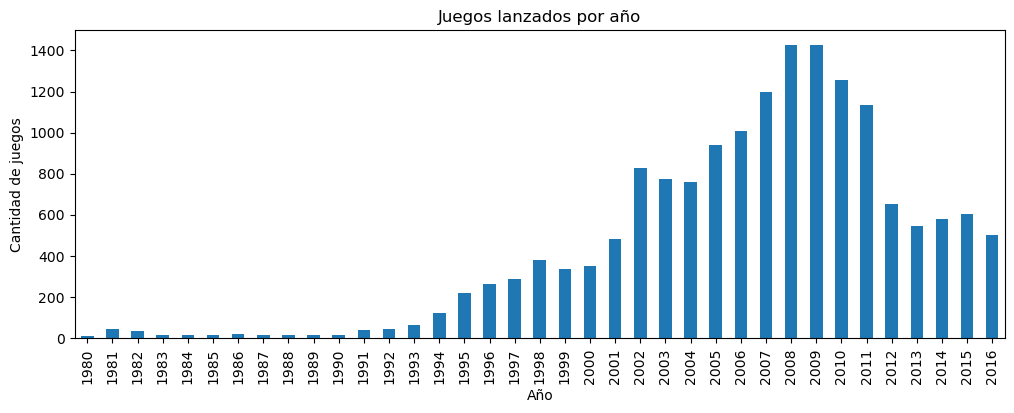

In [6]:
# Juegos por año
df['year_of_release'].value_counts().sort_index().plot(kind='bar', figsize=(12,4), title='Juegos lanzados por año')
plt.ylabel('Cantidad de juegos')
plt.xlabel('Año')
plt.show()


**Juegos lanzados por año a hasta 2016**

La gráfica nos muestra como creció la cantidad de juegos de forma sostenida desde 1995, alcanzando su punto máximo entre 2007 y 2009, para luego disminuir notablemente a partir de 2010. Esto indica un auge en la industria seguido de una contracción en los lanzamientos anuales.

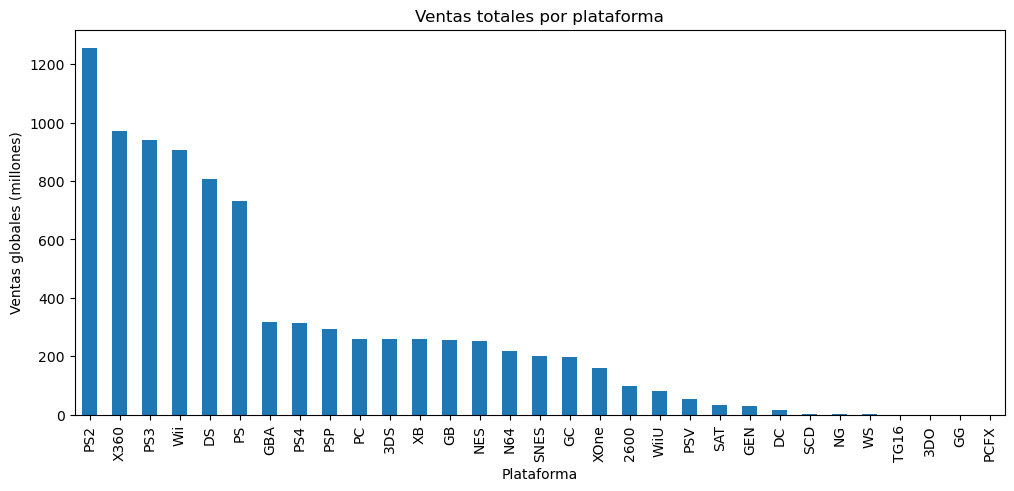

In [7]:
# Ventas totales por plataforma
platform_sales = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platform_sales.plot(kind='bar', figsize=(12,5))
plt.title('Ventas totales por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (millones)')
plt.show()

**Ventas totales por plataforma**

PS2 es la plataforma con mayores ventas globales, seguida por X360, PS3 y Wii. Las consolas de Sony, Microsoft y Nintendo dominan el mercado, mientras que otras plataformas tuvieron ventas considerablemente menores y algunas ya cumplieron su ciclo de vida.

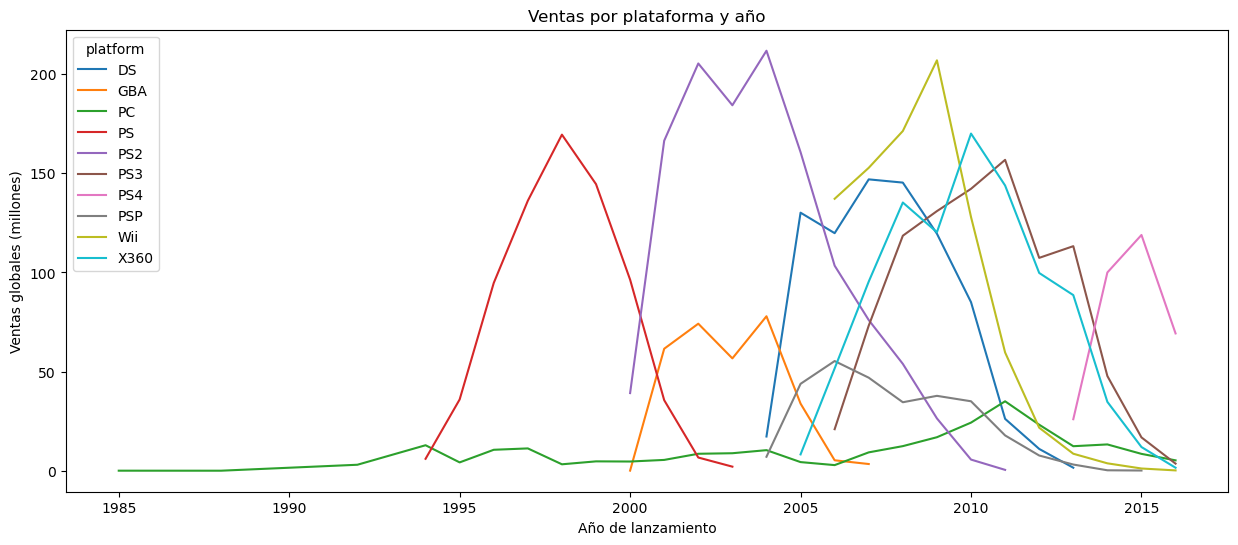

In [8]:
# Distribución de ventas por plataforma y año
top_platforms = platform_sales.head(10).index
df_top = df[df['platform'].isin(top_platforms)]
pivot = df_top.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
pivot.plot(figsize=(15,6))
plt.title('Ventas por plataforma y año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas globales (millones)')
plt.show()

**Plataformas en declive y en crecimiento:**  
Se identifican plataformas que han dejado de tener ventas y otras que están en crecimiento. Esto ayuda a seleccionar plataformas potencialmente rentables.

In [9]:
# Analizamos la duración de las plataformas activas
platform_life = df.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_life['lifespan'] = platform_life['max'] - platform_life['min']
platform_life.sort_values('lifespan', ascending=False)

,min,max,lifespan
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10
Wii,2006,2016,10


**Vida útil de las plataformas:**  
Generalmente, las plataformas tienen una vida útil de 6 a 10 años. 


# Periodo filtrado por los ultimos 5 años

Tomando en cuenta el tiempo de vida de las consolas y la epoca en la que estamos se tomaran en cuentan los últimos 5 años, nos permitira ver el cambio generacional en la que están Sony y
 Microsoft que son las empresas que dominan el mercado.  

 Nota: Se realiza una copia en el filtrado para evitar sobrescribir el DataFrame original y por si es requierido más adelante.  

In [10]:
# Filtramos los juegos lanzados en los ultimos 5 años
df_f5= df[df['year_of_release'] >= 2012].copy()

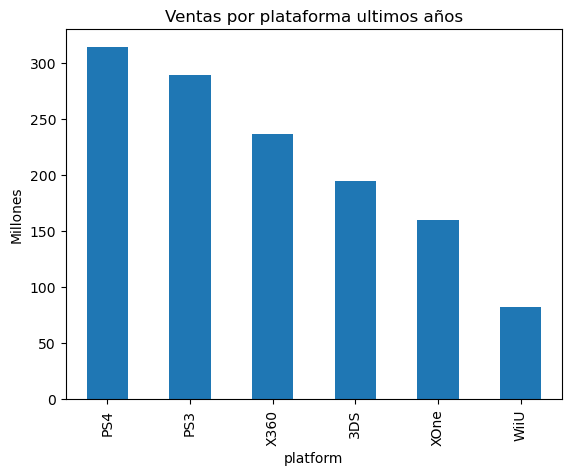

In [11]:
# Calculamos las ventas totales por plataforma
top_platforms = df_f5.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6)
top_platforms.plot(kind='bar', title='Ventas por plataforma ultimos años')
plt.ylabel('Millones')
plt.show()

En los últimos años, las plataformas PS4 y PS3 lideran en ventas, seguidas por Xbox 360, GameBoy 3DS y Xbox One. Sony domina el mercado reciente, mientras que Nintendo tiene las ventas más bajas entre las principales consolas.

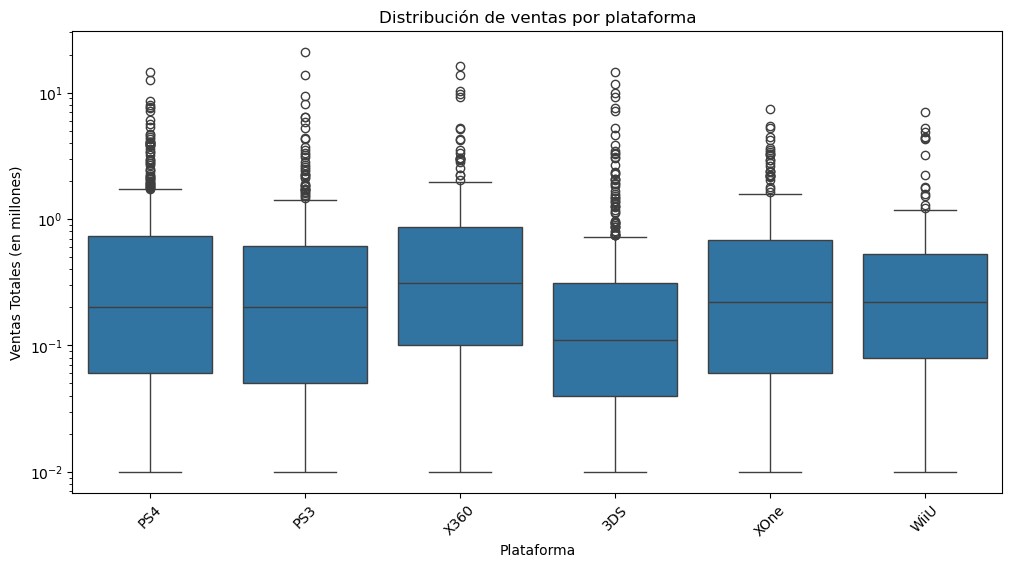

In [12]:
# Creamos boxplot para visualizar la distribución de ventas 
plt.figure(figsize=(12, 6))
sns.boxplot(x='platform', y='total_sales', data=df_f5, order=top_platforms.index)
plt.title('Distribución de ventas por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Ventas Totales (en millones)')
plt.xticks(rotation=45)
plt.yscale('log')  # Usamos escala logarítmica para mejor visualización
plt.show()

**Diferencias en ventas por plataforma:**

Las diferencias en ventas entre plataformas son significativas, con algunas plataformas mostrando una mayor mediana y presencia de valores atípicos que podrían ser juegos muy exitosos ya que se muestra un comportamiento parecido entre las plataformas.

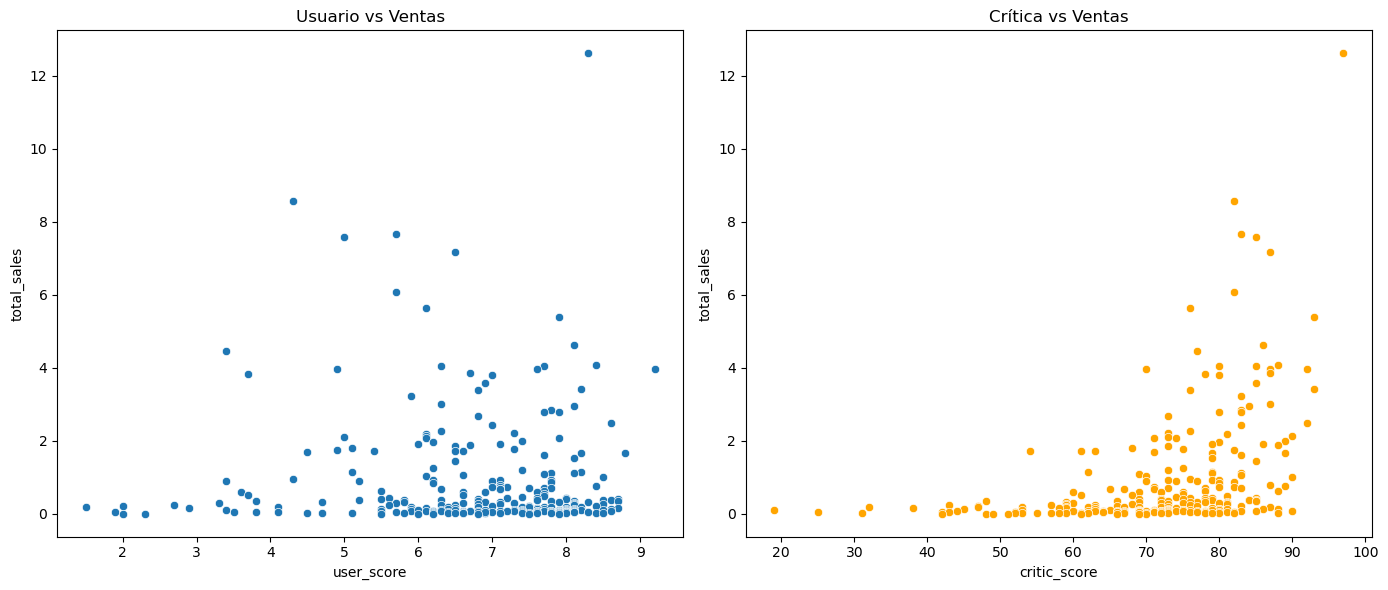

,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.033625
critic_score,0.557654,1.000000,0.405895
total_sales,-0.033625,0.405895,1.000000


In [13]:
# Filtra juegos de PS4 con puntuaciones de usuarios y críticos disponibles
ps4_data = df_f5.query("platform == 'PS4' and user_score.notna() and critic_score.notna()")

# gráficamos usuario vs ventas y crítico vs ventas
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=ps4_data, x='user_score', y='total_sales', ax=ax[0])
ax[0].set_title("Usuario vs Ventas")
sns.scatterplot(data=ps4_data, x='critic_score', y='total_sales', ax=ax[1], color='orange')
ax[1].set_title("Crítica vs Ventas")
plt.tight_layout()
plt.show()

# Calculamos la correlación entre las reseñas de usuarios y y las ventas
ps4_data[['user_score', 'critic_score', 'total_sales']].corr()

**Conclusión sobre reseñas y ventas:**

La correlación entre la puntuación de usuario y las ventas es baja, lo que indica que otros factores pueden influir más en el éxito de ventas.

Nota: La comparación se realizo con la plataforma PS4 debido a que es la plataforma que tiene más ventas.  

In [14]:
# Encontrar juegos que estén disponibles en más de una plataforma
multi_platform_games = df_f5.groupby('name')['platform'].nunique()
shared_games = multi_platform_games[multi_platform_games > 1].index
shared_games_data = df_f5[df_f5['name'].isin(shared_games)]

# Juegos que también están en PS4
ps4_shared = shared_games_data[shared_games_data['platform'] == 'PS4'][['name', 'total_sales']]
ps4_shared = ps4_shared.rename(columns={'total_sales': 'ps4_sales'})

# Unir plataformas
comparison_df = shared_games_data.merge(ps4_shared, on='name')
comparison_df = comparison_df[comparison_df['platform'] != 'PS4']
comparison_df = comparison_df.reset_index(drop=True)

# Ver comparaciones
comparison_df[['name', 'platform', 'total_sales', 'ps4_sales']].head(10)


,name,platform,total_sales,ps4_sales
0,Grand Theft Auto V,PS3,21.05,12.62
1,Grand Theft Auto V,X360,16.27,12.62
2,Call of Duty: Ghosts,X360,10.24,3.83
3,Call of Duty: Ghosts,PS3,9.36,3.83
4,Minecraft,X360,9.18,4.32
5,Call of Duty: Black Ops 3,XOne,7.39,14.63
6,FIFA 14,PS3,6.46,3.01
7,The Last of Us,PS3,5.86,4.72
8,Grand Theft Auto V,XOne,5.47,12.62
9,Call of Duty: Advanced Warfare,XOne,5.26,7.66


**Comparación de ventas de los mismos juegos en diferentes plataformas:**

Se observa que algunos juegos tienen mejores ventas en ciertas plataformas, lo que puede deberse a la base de usuarios, exclusividad o campañas de marketing.

In [15]:
# Agrupación por género para totalizar ventas
genre_sales = df_f5.groupby('genre')['total_sales'].agg(['sum', 'mean', 'count']).sort_values(by='sum', ascending=False)
genre_sales = genre_sales.rename(columns={'sum': 'total_sales', 'mean': 'avg_sales', 'count': 'num_games'})

# Mostrar la tabla
genre_sales.reset_index()

,genre,total_sales,avg_sales,num_games
0,Action,441.12,0.427856,1031
1,Shooter,304.73,1.296723,235
2,Role-Playing,192.80,0.521081,370
3,Sports,181.07,0.675634,268
4,Misc,85.04,0.442917,192
5,Platform,61.00,0.717647,85
6,Racing,53.50,0.465217,115
7,Fighting,44.49,0.408165,109
8,Simulation,35.12,0.439000,80
9,Adventure,29.43,0.097450,302


**Conclusiones:**

- Más populares (en cantidad de lanzamientos): Acción, Shooter y RPG.

- Más rentables por juego: Shooter, seguido por deportes y platforma.

- Menos rentables: Aventura, Estrategia, Puzzle.

Esto sugiere que aunque el genero de acción domina en volumen, los shooters son los más efectivos por unidad. Juegos Adventure son comunes pero con ventas bajas, lo que puede ser una mala inversión si no están bien posicionados.

## 4. Perfil de usuario por región


In [16]:
# Función para obtener top 5 plataformas y géneros por región
def top5_by_region(region_col):
    top_platforms = df_f5.groupby('platform')[region_col].sum().sort_values(ascending=False).head(5)
    top_genres = df_f5.groupby('genre')[region_col].sum().sort_values(ascending=False).head(5)
    return top_platforms, top_genres

na_platforms, na_genres = top5_by_region('na_sales')
eu_platforms, eu_genres = top5_by_region('eu_sales')
jp_platforms, jp_genres = top5_by_region('jp_sales')

print("Top 5 plataformas en NA:\n", na_platforms)
print("\nTop 5 géneros en NA:\n", na_genres)
print("\nTop 5 plataformas en EU:\n", eu_platforms)
print("\nTop 5 géneros en EU:\n", eu_genres)
print("\nTop 5 plataformas en JP:\n", jp_platforms)
print("\nTop 5 géneros en JP:\n", jp_genres)

Top 5 plataformas en NA:
 platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

Top 5 géneros en NA:
 genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

Top 5 plataformas en EU:
 platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

Top 5 géneros en EU:
 genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64

Top 5 plataformas en JP:
 platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

Top 5 géneros en JP:
 genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64


**Conclusiones por región:**

- Las plataformas y géneros más populares varían entre regiones.
- En Japón, las plataformas portátiles y los géneros de rol son más populares.
- En NA y EU, dominan las consolas de sobremesa y los géneros de acción y deportes.

Ventas por clasificación ESRB en NA:
 rating
M          231.57
E          114.37
unknown    103.31
E10+        75.70
T           66.02
Name: na_sales, dtype: float64

Ventas por clasificación ESRB en EU:
 rating
M          193.96
E          113.03
unknown     91.50
E10+        55.37
T           52.96
Name: eu_sales, dtype: float64

Ventas por clasificación ESRB en JP:
 rating
unknown    108.84
E           28.33
T           26.02
M           21.20
E10+         8.19
Name: jp_sales, dtype: float64


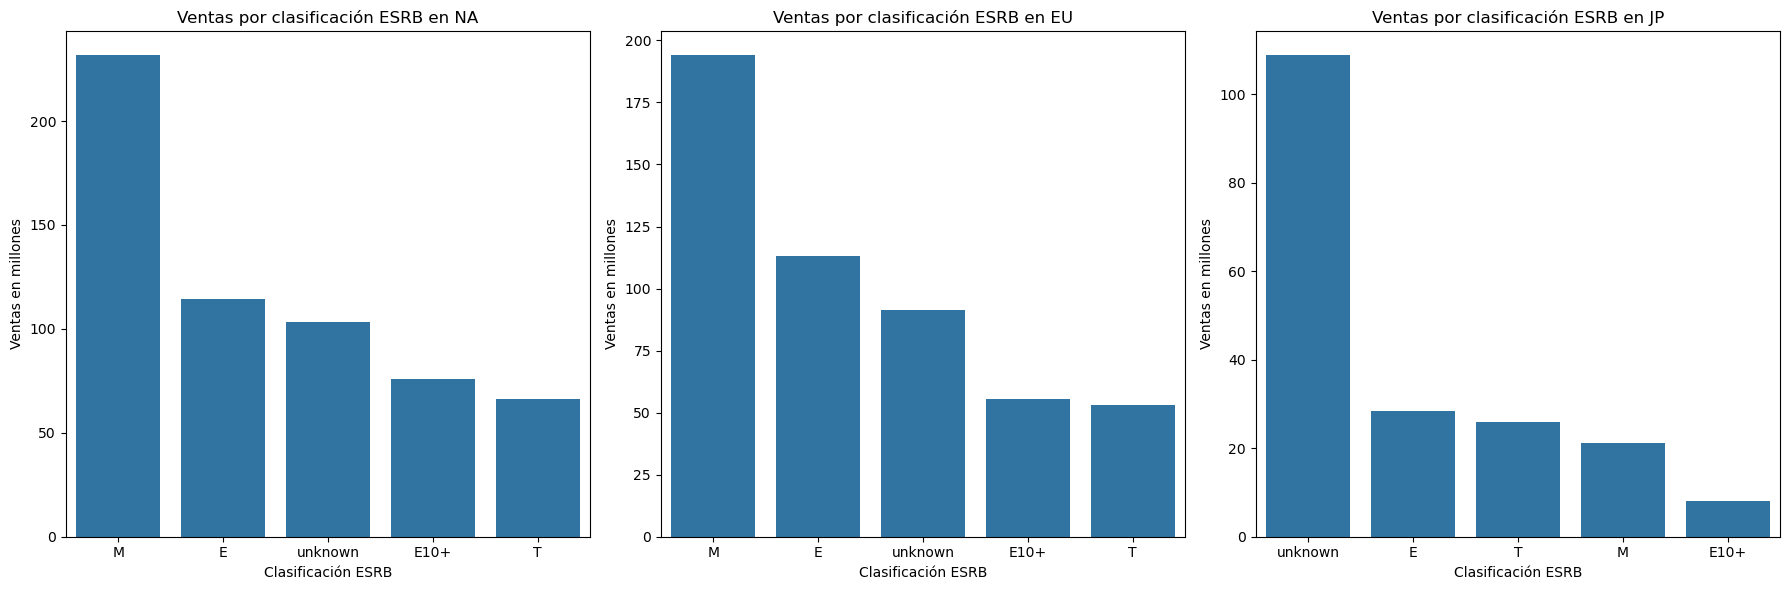

In [21]:
# Impacto de la clasificación ESRB en ventas por región
esrb_na = df_f5.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
esrb_eu = df_f5.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
esrb_jp = df_f5.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

print("Ventas por clasificación ESRB en NA:\n", esrb_na)
print("\nVentas por clasificación ESRB en EU:\n", esrb_eu)
print("\nVentas por clasificación ESRB en JP:\n", esrb_jp)

# graficamos el impacto de la clasificación ESRB en ventas por región
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=esrb_na.index, y=esrb_na.values, ax=ax[0])
ax[0].set_title('Ventas por clasificación ESRB en NA')
ax[0].set_ylabel('Ventas en millones')
ax[0].set_xlabel('Clasificación ESRB')      
sns.barplot(x=esrb_eu.index, y=esrb_eu.values, ax=ax[1])
ax[1].set_title('Ventas por clasificación ESRB en EU')
ax[1].set_ylabel('Ventas en millones')
ax[1].set_xlabel('Clasificación ESRB')
sns.barplot(x=esrb_jp.index, y=esrb_jp.values, ax=ax[2])
ax[2].set_title('Ventas por clasificación ESRB en JP')
ax[2].set_ylabel('Ventas en millones')
ax[2].set_xlabel('Clasificación ESRB')
plt.tight_layout()
plt.show()



- La clasificación ESRB tiene un impacto variable según la región.

## 5. Pruebas de hipótesis


### Hipótesis 1: Calificaciones promedio de usuarios para Xbox One y PC

- **Hipótesis nula (H0):** Las calificaciones promedio de los usuarios para Xbox One y PC son iguales.
- **Hipótesis alternativa (H1):** Las calificaciones promedio de los usuarios para Xbox One y PC son diferentes.

Se utilizará una prueba t de Student para muestras independientes, ya que se comparan medias de dos grupos independientes.

Se establece un valor alfa de 0.05.

p-value: 0.5490
No se puede rechazar la hipótesis nula: no hay diferencia significativa en las calificaciones promedio.
T-statistic: 0.5998585993590415, P-value: 0.5489537965134912


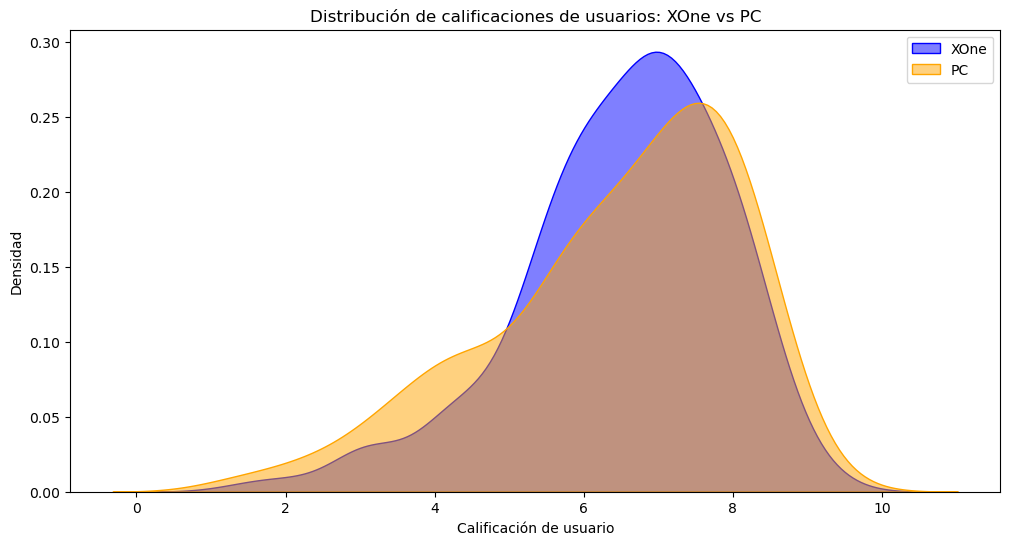

In [18]:
# Filtrar datos para Xbox One y PC, eliminando valores ausentes
xone_scores = df_f5[(df_f5['platform'] == 'XOne') & (~df_f5['user_score'].isnull())]['user_score']
pc_scores = df_f5[(df_f5['platform'] == 'PC') & (~df_f5['user_score'].isnull())]['user_score']

# Prueba t de Student
t_stat, p_value = stats.ttest_ind(xone_scores, pc_scores, equal_var=False)
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencia significativa en las calificaciones promedio.")
else:
    print("No se puede rechazar la hipótesis nula: no hay diferencia significativa en las calificaciones promedio.")

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Visualización de la distribución de calificaciones
plt.figure(figsize=(12, 6))
sns.kdeplot(x=xone_scores, label='XOne', color='blue', fill=True, alpha=0.5)
sns.kdeplot(x=pc_scores, label='PC', color='orange', fill=True, alpha=0.5)
plt.title('Distribución de calificaciones de usuarios: XOne vs PC')
plt.xlabel('Calificación de usuario')
plt.ylabel('Densidad')
plt.legend()
plt.show()

**Conclusion:**

No existe diferencia significativa en las calificaciones de usuarios entre Xbox One y PC (*p-value = 0.549*). La satisfacción de los usuarios es estadísticamente similar en ambas plataformas.

### Hipótesis 2: Calificaciones promedio de usuarios para los géneros Acción y Deportes

- **Hipótesis nula (H0):** Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son iguales.
- **Hipótesis alternativa (H1):** Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son diferentes.

Se utilizará una prueba t de Student para muestras independientes.

Se establece un valor alfa de 0.05.

p-value: 0.0000
Rechazamos la hipótesis nula: hay diferencia significativa en las calificaciones promedio entre géneros.
T-statistic: 9.903191188722607, P-value: 4.24307776572644e-20


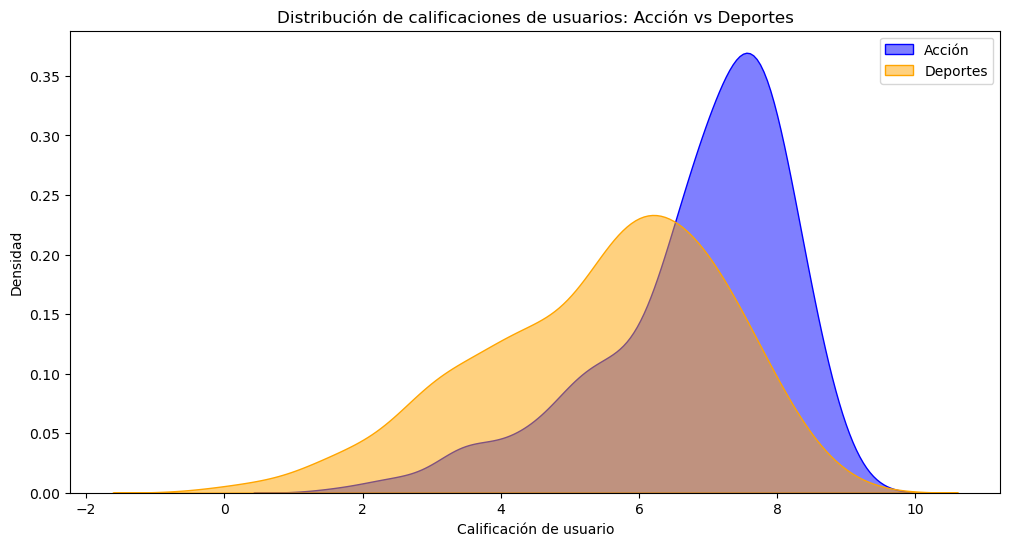

In [19]:
#prueba de hipotesis para comparar el promedio de usuarios para los generos de acción y deportes
action_scores = df_f5[df_f5['genre'] == 'Action']['user_score'].dropna()
sports_scores = df_f5[df_f5['genre'] == 'Sports']['user_score'].dropna()
resultado = stats.ttest_ind(action_scores, sports_scores, equal_var=False)
t_stat = resultado.statistic
p_value = resultado.pvalue
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencia significativa en las calificaciones promedio entre géneros.")
else:
    print("No se puede rechazar la hipótesis nula: no hay diferencia significativa en las calificaciones promedio entre géneros.")

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Visualización de la distribución de calificaciones por género
plt.figure(figsize=(12, 6))
sns.kdeplot(x=action_scores, label='Acción', color='blue', fill=True, alpha=0.5)
sns.kdeplot(x=sports_scores, label='Deportes', color='orange', fill=True, alpha=0.5)
plt.title('Distribución de calificaciones de usuarios: Acción vs Deportes')
plt.xlabel('Calificación de usuario')
plt.ylabel('Densidad')
plt.legend()
plt.show()


Hay una diferencia significativa entre las calificaciones promedio de usuarios para los géneros Acción y Deportes (p < 0.05).
El estadístico t alto indica que la diferencia entre los promedios es considerable en relación con la variabilidad de los datos.
Los usuarios califican estos géneros de manera distinta.



## Conclusión final

La conclusión final del análisis de datos sobre videojuegos es la siguiente:

- **Tendencias del mercado:** El mercado de videojuegos es dinámico, con plataformas que surgen y desaparecen en ciclos de aproximadamente 6 a 10 años. En los últimos años, las consolas de sobremesa han dominado en ventas globales, aunque en Japón las portátiles y los juegos de rol son más populares, Sony domina con sus plataformas PS4 y PS3 lideran el mercado, Xbox está en segundo mientras que Nintendo tiene las ventas más bajas entre las principales consolas. 

- **Ventas por plataforma y género:** Existen diferencias significativas en las ventas entre plataformas y géneros. Los géneros de acción y shooter son los más populares en cantidad de lanzamientos, pero los shooters y deportes son los más rentables por juego. Los géneros como aventura y puzzle, aunque frecuentes, suelen tener ventas bajas.

- **Factores de éxito:** No existe una correlación fuerte entre las calificaciones de usuarios o críticos y las ventas, lo que indica que otros factores como marketing, exclusividad o base de usuarios influyen más en el éxito comercial.

- **Preferencias regionales:** Las preferencias de plataformas y géneros varían considerablemente entre regiones. En Norteamérica y Europa predominan los juegos de acción y deportes en consolas de sobremesa, mientras que en Japón destacan los juegos de rol y las portátiles.

- **Clasificación ESRB:** La clasificación de los juegos tiene un impacto variable en las ventas según la región, siendo más relevante en Norteamérica y Europa.

- **Pruebas de hipótesis:** No hay diferencia significativa en las calificaciones promedio de usuarios entre Xbox One y PC, pero sí entre los géneros de acción y deportes, lo que muestra que los usuarios perciben estos géneros de manera distinta.

**En resumen:**  
El éxito de un videojuego depende de una combinación de plataforma, género, región y factores externos al producto en sí. Para maximizar ventas, es clave considerar las tendencias del mercado, las preferencias regionales y la segmentación adecuada del público objetivo.